# ANÁLISIS EXPLORATORIO BIVARIADO


In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from scipy.stats import anderson, levene, chi2_contingency

# Carga del dataset y construcción del dataframe de trabajo
datos = pd.read_csv("/Users/pctm/Downloads/data_payments.csv")

df = datos.rename(columns={
    'KEY': 'ID',
    'REF_AREA': 'COUNTRY_ORIGIN',
    'COUNT_AREA': 'COUNTRY_DESTINATION',
    'TYP_TRNSCTN': 'TYPE_TRX',
    'RL_TRNSCTN': 'TYPE_PSP',
    'FRD_TYP': 'TYPE_FRAUD',
    'UNIT_MEASURE': 'UNIT_',   
    'TIME_PERIOD': 'YEAR',
    'OBS_VALUE': 'AMOUNT',
    'OBS_STATUS': 'TYPE_AMOUNT',
    'TITLE': 'DESCRIPTION'
})

datos2 = df[[  
    'ID','FREQ','COUNTRY_ORIGIN','COUNTRY_DESTINATION',
    'TYPE_TRX','TYPE_PSP','TYPE_FRAUD',  'UNIT_',
    'YEAR','AMOUNT','TYPE_AMOUNT','DECIMALS',
    'DESCRIPTION','UNIT_MULT'
]]

datos2.head()

,ID,FREQ,COUNTRY_ORIGIN,COUNTRY_DESTINATION,TYPE_TRX,TYPE_PSP,TYPE_FRAUD,UNIT_,YEAR,AMOUNT,TYPE_AMOUNT,DECIMALS,DESCRIPTION,UNIT_MULT
0,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,_Z,PN,2014,0.242,A,3,"Total payment transactions, incl. cash withdra...",6
1,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,_Z,PN,2015,0.268,A,3,"Total payment transactions, incl. cash withdra...",6
2,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,_Z,PN,2016,0.689,A,3,"Total payment transactions, incl. cash withdra...",6
3,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,_Z,PN,2017,0.632,A,3,"Total payment transactions, incl. cash withdra...",6
4,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,_Z,PN,2018,0.615,A,3,"Total payment transactions, incl. cash withdra...",6



## Análisis de la variable de respuesta frente a las variables numéricas

Realizaremos la comparación de la variable TYPE_FRAUD correspondiente al tipo de fraude con la única variable númerica del dataset, la cual es AMOUNT correspondiente al valor de la transacción. En este caso, la variable de respuesta solo tiene dos opciones: _Z (No aplica) y F (fraude), por tanto, se tomarán estos dos grupos y se analizará el valor de la transacción mediante el grafico de caja y bigotes bivariado para estas variables y se compararán las medias de estos dos grupos independientes, para ello se verificarán los supuestos de normalidad e igualdad de varianza para elegir la prueba correspondiente para al caso.

### Gráfico de caja y bigotes

/var/folders/x3/pv5pxgpn24d3dg_tsmkjptgc0000gn/T/ipykernel_89534/3418345154.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grupos, labels=etiquetas, patch_artist=True,


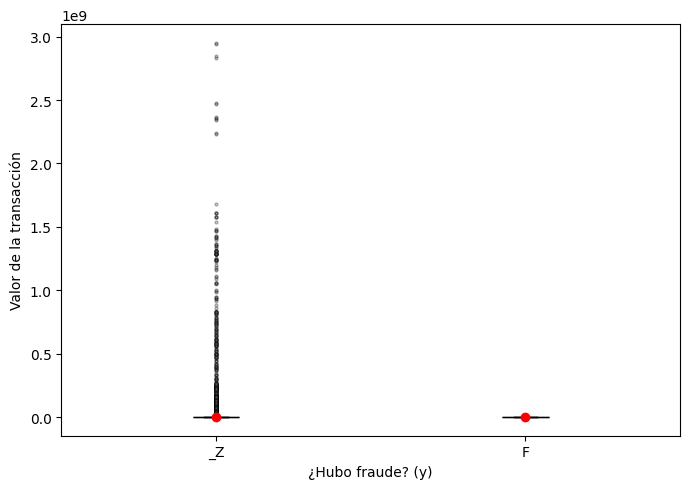

In [ ]:
# Boxplot bivariado: AMOUNT según TYPE_FRAUD
fig, ax = plt.subplots(figsize=(7, 5))

# Grupos para el boxplot
grupos = [datos2[datos2['TYPE_FRAUD'] == g]['AMOUNT'].dropna() for g in datos2['TYPE_FRAUD'].unique()]
etiquetas = list(datos2['TYPE_FRAUD'].unique())

bp = ax.boxplot(grupos, labels=etiquetas, patch_artist=True,
                boxprops=dict(facecolor='#1E90FF', alpha=0.6, color='black'),
                medianprops=dict(color='black'),
                flierprops=dict(markerfacecolor='gray', marker='o', markersize=2, alpha=0.3))

# Punto de la media (equivalente a stat_summary fun=mean)
for i, g in enumerate(grupos, start=1):
    ax.plot(i, g.mean(), marker='o', color='red', markersize=6, zorder=5)

ax.set_xlabel('¿Hubo fraude? (y)')
ax.set_ylabel('Valor de la transacción')
plt.tight_layout()
plt.show()

El gráfico muestra la distribución del valor de la transacciones según su respuesta a si hubo o no fraude, diferenciando entre _Z(no hubo fraude) y F(Si hubo fraude) en la transacción. Se puede apreciar que es imposible hacer una inferencia de este gráfico bivariado porque hay muchos valores atípicos, pero según el contexto del dataset no se pueden remover porque puedes ser transacciones de un gran valor correspondiente a personas o entidades con gran capital que no son muy tipicas.

Debido a lo anterior, se hará un mejor análisis mediante un histograma la distribución de ambas muestras.

### Histogramas

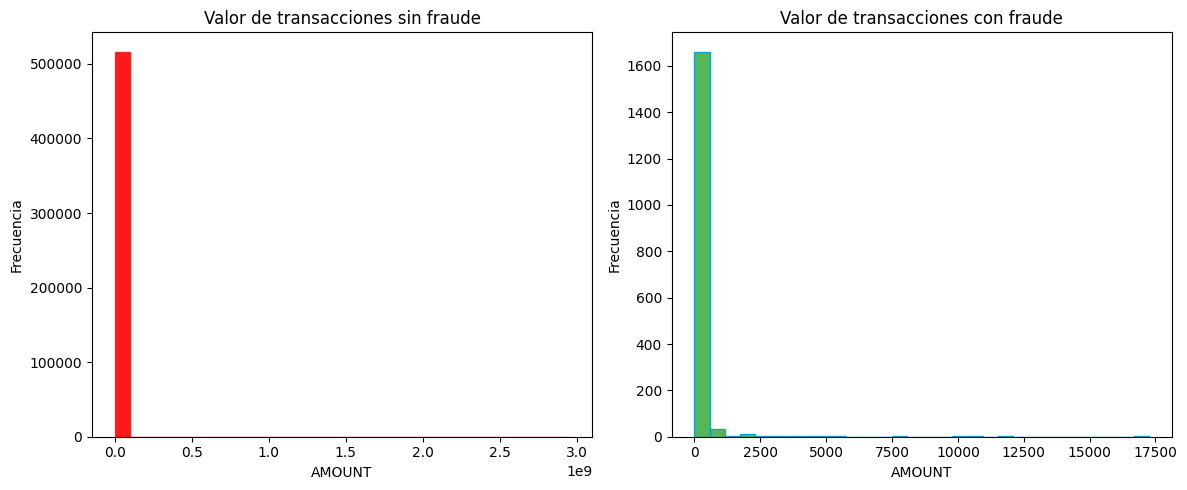

In [ ]:
# Histogramas lado a lado: sin fraude (_Z) y con fraude (F)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma sin fraude
ax1.hist(datos2[datos2['TYPE_FRAUD'] == '_Z']['AMOUNT'].dropna(),
         bins=30, color='#FD0000', edgecolor='#E52521', alpha=0.9)
ax1.set_title('Valor de transacciones sin fraude')
ax1.set_xlabel('AMOUNT')
ax1.set_ylabel('Frecuencia')

# Histograma con fraude
ax2.hist(datos2[datos2['TYPE_FRAUD'] == 'F']['AMOUNT'].dropna(),
         bins=30, color='#43B047', edgecolor='#049DCB', alpha=0.9)
ax2.set_title('Valor de transacciones con fraude')
ax2.set_xlabel('AMOUNT')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Los dos histogramas muestran la distribución de los valores de las transacción en los dos grupos _Z(no hay fraude) y F(hay fraude). Se aprecia una mayor concentración de observaciones en los valores entorno al 0, mientras que la frecuencia disminuye progresivamente a medida que aumentan los valores. Además, se aprecia que donde no hubo fraude los montos de las transacciones son menores que en los casos donde si hubo fraude. A su vez, se observa una extendida cola hacia la derecha en ambos gráficos y sugiere una pronunciada asimetría positiva en la distribución de ambas muestras; con base en esta evidencia es muy probable que los dos grupos no sigan una distribución normal.

### Comparación de ambas muestras

Gracias a lo anterior, se realizará el análisis de la media de los valores de las transacciones en los grupos donde hubo y no hubo fraude. Para ello se procede realizar un análisis descriptivo básico entre los dos grupos.

In [ ]:
# Estadísticas descriptivas por grupo (equivalente a group_by + summarise en R)
def resumen(grupo):
    col = grupo['AMOUNT'].dropna()
    return pd.Series({
        'n':          len(grupo['AMOUNT']),
        'media':      col.mean(),
        'ds':         col.std(),
        'mediana':    col.median(),
        'minimo':     col.min(),
        'maximo':     col.max(),
        'Q1':         col.quantile(0.25),
        'Q3':         col.quantile(0.75),
        'IQR':        col.quantile(0.75) - col.quantile(0.25)
    })

tabla_grupos = datos2.groupby('TYPE_FRAUD').apply(resumen).reset_index()

# Fila total
col_total = datos2['AMOUNT'].dropna()
tabla_total = pd.DataFrame([{
    'TYPE_FRAUD': 'TOTAL',
    'n':          len(datos2['AMOUNT']),
    'media':      col_total.mean(),
    'ds':         col_total.std(),
    'mediana':    col_total.median(),
    'minimo':     col_total.min(),
    'maximo':     col_total.max(),
    'Q1':         col_total.quantile(0.25),
    'Q3':         col_total.quantile(0.75),
    'IQR':        col_total.quantile(0.75) - col_total.quantile(0.25)
}])

# Tabla final (equivalente a bind_rows + kable)
pd.concat([tabla_grupos, tabla_total], ignore_index=True).round(2)

/var/folders/x3/pv5pxgpn24d3dg_tsmkjptgc0000gn/T/ipykernel_89534/857880937.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tabla_grupos = datos2.groupby('TYPE_FRAUD').apply(resumen).reset_index()


,TYPE_FRAUD,n,media,ds,mediana,minimo,maximo,Q1,Q3,IQR
0,F,1944.0,102.26,734.52,0.12,0.0,1.726444e+04,0.0,8.07,8.07
1,_Z,660672.0,640706.76,22185244.60,0.79,-100.0,2.950583e+09,0.0,151.37,151.37
2,TOTAL,662616.0,638575.28,22148336.17,0.78,-100.0,2.950583e+09,0.0,149.06,149.06


La distribución del valor de las transacciones según hubo fraude o no muestran diferencias relevantes en las medidas de tendencia central, se observa que la media es considerablemente mayor en el grupo sin fraude que en el grupo con fraude; sin embargo, las medianas en ambos casos son cercanas a cero, lo que indica una distribución fuertemente asimétrica hacia la derecha. Esta asimetría se confirma por las desviaciones estándar extremadamente elevadas y por la presencia de valores máximos muy grandes, lo que sugiere la existencia de valores atípicos significativos. En este contexto, la mediana y el rango intercuartílico resultan medidas más representativas que la media, y podría considerarse una transformación logarítmica para estabilizar la varianza y mejorar el análisis, sin embargo, existen valores negativos y no es muy viable.

### Prueba de normalidad

En esta ocasión se usará la prueba de Anderson-Darling porque las muestras son grandes y con cola hacia la derecha muy pronunciada.

In [ ]:
# Prueba Anderson-Darling para ambos grupos (equivalente a ad.test() de nortest en R)
grupo_F  = datos2[datos2['TYPE_FRAUD'] == 'F']['AMOUNT'].dropna()
grupo_Z  = datos2[datos2['TYPE_FRAUD'] == '_Z']['AMOUNT'].dropna()

res_F = anderson(grupo_F, dist='norm')
res_Z = anderson(grupo_Z, dist='norm')

print("=== Anderson-Darling: Grupo F (con fraude) ===")
print(f"Estadístico: {res_F.statistic:.4f}")
print(f"Valor crítico al 5%: {res_F.critical_values[2]:.4f}")
print(f"Resultado: {'Rechaza H0 (no normal)' if res_F.statistic > res_F.critical_values[2] else 'No rechaza H0'}")

print("\n=== Anderson-Darling: Grupo _Z (sin fraude) ===")
print(f"Estadístico: {res_Z.statistic:.4f}")
print(f"Valor crítico al 5%: {res_Z.critical_values[2]:.4f}")
print(f"Resultado: {'Rechaza H0 (no normal)' if res_Z.statistic > res_Z.critical_values[2] else 'No rechaza H0'}")

=== Anderson-Darling: Grupo F (con fraude) ===
Estadístico: 555.7771
Valor crítico al 5%: 0.7850
Resultado: Rechaza H0 (no normal)

=== Anderson-Darling: Grupo _Z (sin fraude) ===
Estadístico: 195608.1063
Valor crítico al 5%: 0.7870
Resultado: Rechaza H0 (no normal)


Con un nivel de confianza del 95% y dado que en ambas pruebas el p-valor es menor a 0.05, se puede concluir que ambas problaciones no siguen una distribución normal.

### Homocedasticidad

En este inciso se usará el test de levene para comprobar la igualdad de varianza en ambos grupos.

In [ ]:
# Test de Levene para igualdad de varianzas (equivalente a leveneTest() de car en R)
stat, p_valor = levene(grupo_F, grupo_Z)

print("=== Test de Levene ===")
print(f"Estadístico F: {stat:.4f}")
print(f"p-valor:       {p_valor:.4f}")
print(f"Resultado: {'No rechaza H0 (varianzas iguales)' if p_valor > 0.05 else 'Rechaza H0 (varianzas distintas)'}")

=== Test de Levene ===
Estadístico F: 1.4391
p-valor:       0.2303
Resultado: No rechaza H0 (varianzas iguales)


Con un nivel de confianza del 95% y dado que la prueba arrojó un p-valor mayor a 0.05, se puede concluir que ambas problaciones tienen varianzas iguales.

## Análisis de la variable de respuesta frente a las variables categóricas independientes.

### Variable ID

In [ ]:
# Tabla de distribución de ID según TYPE_FRAUD (primeras 40 filas)
tabla_ID = (
    datos2.groupby('TYPE_FRAUD')['ID']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'ID': 'categoria'})
    .assign(variable='ID')
)
tabla_ID['porcentaje'] = tabla_ID.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100)
tabla_ID = tabla_ID[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_ID.head(40)

,TYPE_FRAUD,variable,categoria,n,porcentaje
0,F,ID,PAY.H.AT.W0.CP0.1.F.N.EUR,7,0.360082
1,F,ID,PAY.H.AT.W0.CP0.1.F.N.PN,7,0.360082
2,F,ID,PAY.H.AT.W0.CP0.2.F.N.EUR,7,0.360082
3,F,ID,PAY.H.AT.W0.CP0.2.F.N.PN,7,0.360082
4,F,ID,PAY.H.AT.W0.CT0.1.F.N.EUR,7,0.360082
5,F,ID,PAY.H.AT.W0.CT0.1.F.N.PN,7,0.360082
6,F,ID,PAY.H.AT.W0.DD.2.F.N.EUR,7,0.360082
7,F,ID,PAY.H.AT.W0.DD.2.F.N.PN,7,0.360082
8,F,ID,PAY.H.AT.W0.EMP0.1.F.N.EUR,7,0.360082
9,F,ID,PAY.H.AT.W0.EMP0.1.F.N.PN,7,0.360082


Para este analisis la variable ID se excluye frente a TYPE_FRAUD porque presenta baja frecuencia por categoría, haciendo que sea poco interpretable. Además, ID corresponde a un código estructural compuesto que integra múltiples atributos técnicos, por lo que no representa una característica explicativa independiente con significado analítico propio. Cabe aclarar que aparecen pocas filas porque solo se mostraron las 40 primeras. Asimismo, no se realizará la prueba de independencia para esta variable con la de respuesta porque no es necesario para nuestro análisis y por la forma de esta variable.

### Variable FREQ

In [ ]:
# Tabla de distribución de FREQ según TYPE_FRAUD
tabla_FREQ = (
    datos2.groupby('TYPE_FRAUD')['FREQ']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'FREQ': 'categoria'})
    .assign(variable='FREQ')
)
tabla_FREQ['porcentaje'] = tabla_FREQ.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_FREQ = tabla_FREQ[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_FREQ

,TYPE_FRAUD,variable,categoria,n,porcentaje
0,F,FREQ,H,1944,100.00
1,_Z,FREQ,A,275179,41.65
2,_Z,FREQ,H,234940,35.56
3,_Z,FREQ,Q,150553,22.79


La distribución de la frecuencia con que se hacen las transacciones según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. En los casos donde hubo fraude el 100% corresponden a transacciones con frecuencia H(mitad de año). En contraste, en el grupo donde no hubo fraude, la mayoría de transacciones (41.65%) fueron A(anuales), pero la proporción donde la transacción fue H(mitad de año) y Q(trimestral) es menor. Esta diferencia sugiere que las transacciones realizadas con frecuencia a mitad de año son más propensas a que sean fraude y en otro caso es casi nula esta posibilidad.

**Gráfico de barras multiple**

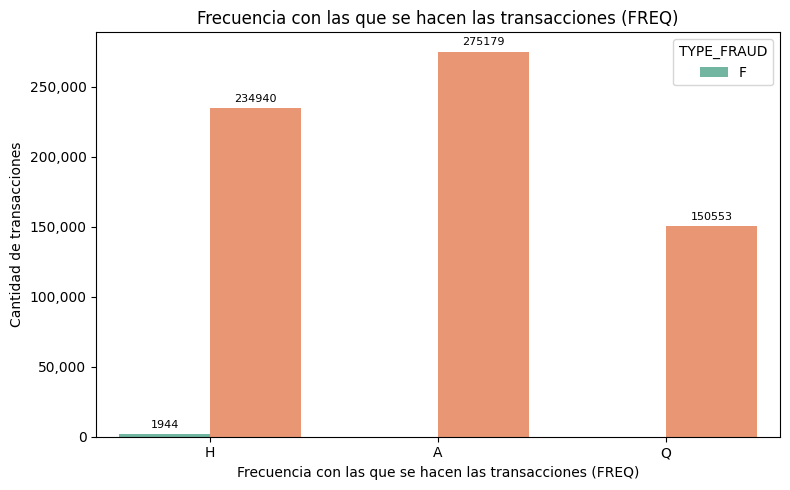

In [ ]:
# Gráfico de barras múltiple: FREQ vs TYPE_FRAUD
df_plot = tabla_FREQ.copy()

plt.figure(figsize=(8, 5))
sns.barplot(x='categoria', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

# Etiquetas sobre cada barra
ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Frecuencia con las que se hacen las transacciones (FREQ)')
plt.xlabel('Frecuencia con las que se hacen las transacciones (FREQ)')
plt.ylabel('Cantidad de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico muestra que la gran mayoría de las transacciones corresponden a la clase no fraude (_Z), distribuyéndose principalmente en las categorías A (41.7%) y H (35.6%), mientras que Q representa una proporción menor. En contraste, los casos de fraude (F) son extremadamente pocos y se concentran completamente en una sola categoría de frecuencia (H), lo que evidencia el fuerte desbalance de la variable respuesta.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado de independencia: FREQ vs TYPE_FRAUD (equivalente a chisq.test en R)
tabla_freq_chi = pd.crosstab(datos2['FREQ'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_freq_chi)

print("=== Chi-cuadrado: FREQ vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: FREQ vs TYPE_FRAUD ===
Estadístico X²: 3504.0706
p-valor:        0.0000e+00
Grados de libertad: 2
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable FREQ y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende de la frecuencia con la que se realiza determinado pago.

### Variable COUNTRY_ORIGIN

In [ ]:
# Tabla de distribución de COUNTRY_ORIGIN según TYPE_FRAUD
tabla_COUNTRY = (
    datos2.groupby('TYPE_FRAUD')['COUNTRY_ORIGIN']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'COUNTRY_ORIGIN': 'categoria'})
    .assign(variable='COUNTRY_ORIGIN')
)
tabla_COUNTRY['porcentaje'] = tabla_COUNTRY.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_COUNTRY = tabla_COUNTRY[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_COUNTRY

,TYPE_FRAUD,variable,categoria,n,porcentaje
27,_Z,COUNTRY_ORIGIN,RO,28746,4.35
28,_Z,COUNTRY_ORIGIN,HU,28724,4.35
29,_Z,COUNTRY_ORIGIN,PL,28203,4.27
30,_Z,COUNTRY_ORIGIN,CZ,28063,4.25
31,_Z,COUNTRY_ORIGIN,NL,27204,4.12
32,_Z,COUNTRY_ORIGIN,PT,25600,3.87
33,_Z,COUNTRY_ORIGIN,LT,25520,3.86
34,_Z,COUNTRY_ORIGIN,DE,25149,3.81
35,_Z,COUNTRY_ORIGIN,FI,25092,3.80
36,_Z,COUNTRY_ORIGIN,LU,25086,3.80


La distribución del país de origen según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. En los 3 casos donde hubo mayor fraude el 5.86% corresponden a transacciones del país U2, el 5.76% del BO y el 3.8% de ES. En contraste, en el grupo donde no hubo fraude, la mayoría del 4.35% fueron del pais RO, pero la proporción del país HU(4.34%) y PL(4.26%) es ligeramente menor. Esta diferencia sugiere que las transacciones realizadas en los paises U", BO y ES son más propensas a que sean fraude, mientras que las transacciones de paises como RO, HU y PL tienden a a que no haya fraude, lo que podría ser clave para estrategias de ssegmentación o análisis de comportamiento.

**Gráfico de barras multiple**

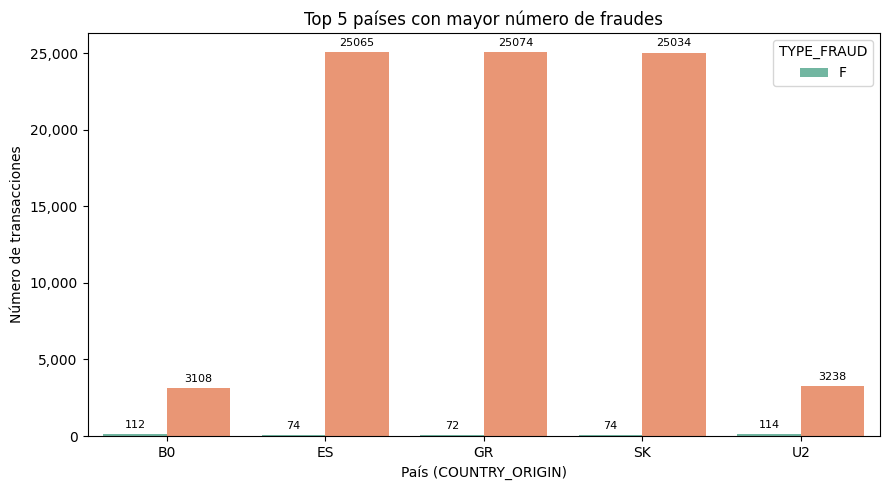

In [ ]:
# Top 5 países con mayor número de fraudes
top5_paises = (
    datos2[datos2['TYPE_FRAUD'] == 'F']['COUNTRY_ORIGIN']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['COUNTRY_ORIGIN'].isin(top5_paises)]
    .groupby(['COUNTRY_ORIGIN', 'TYPE_FRAUD'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('COUNTRY_ORIGIN')['n'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(9, 5))
sns.barplot(x='COUNTRY_ORIGIN', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Top 5 países con mayor número de fraudes')
plt.xlabel('País (COUNTRY_ORIGIN)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico muestra que, aunque estos cinco países concentran el mayor número absoluto de fraudes, la proporción de transacciones fraudulentas dentro de cada país sigue siendo muy baja en comparación con las no fraudulentas. En todos los casos, más del 96% de las transacciones corresponden a la categoría _Z (no fraude), mientras que los fraudes (F) representan entre aproximadamente 0.3% y 3.5% del total por país. Por tanto, esto sigue demostrando el fuerte desvalance de la variable de respuesta.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: COUNTRY_ORIGIN vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['COUNTRY_ORIGIN'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: COUNTRY_ORIGIN vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: COUNTRY_ORIGIN vs TYPE_FRAUD ===
Estadístico X²: 2288.8730
p-valor:        0.0000e+00
Grados de libertad: 28
Resultado: Rechaza H0 (dependientes)


Se rechaza HO: no hay evidencia suficiente para afirmar que la variable COUNTRY_ORIGIN y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende del país de origen.

### Variable COUNTRY_DESTINATION

In [ ]:
# Tabla de distribución de COUNTRY_DESTINATION según TYPE_FRAUD
tabla_ORGANIZATION = (
    datos2.groupby('TYPE_FRAUD')['COUNTRY_DESTINATION']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'COUNTRY_DESTINATION': 'categoria'})
    .assign(variable='COUNTRY_DESTINATION')
)
tabla_ORGANIZATION['porcentaje'] = tabla_ORGANIZATION.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_ORGANIZATION = tabla_ORGANIZATION[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_ORGANIZATION

,TYPE_FRAUD,variable,categoria,n,porcentaje
1,_Z,COUNTRY_DESTINATION,W0,86789,13.14
2,_Z,COUNTRY_DESTINATION,W1,21755,3.29
3,_Z,COUNTRY_DESTINATION,W2,21507,3.26
4,_Z,COUNTRY_DESTINATION,G1,17392,2.63
5,_Z,COUNTRY_DESTINATION,SE,16057,2.43
6,_Z,COUNTRY_DESTINATION,DK,15769,2.39
7,_Z,COUNTRY_DESTINATION,BG,15488,2.34
8,_Z,COUNTRY_DESTINATION,GR,15440,2.34
12,_Z,COUNTRY_DESTINATION,SK,15437,2.34
11,_Z,COUNTRY_DESTINATION,SI,15437,2.34


La distribución de COUNTRY_DESTINATION según TYPE_FRAUD muestra que las transacciones no fraudulentas (_Z) se encuentran ampliamente distribuidas entre diversas áreas geográficas, destacándose W0 como la categoría con mayor participación (13.13%), seguida por W1 y W2, mientras que el resto de áreas presentan proporciones relativamente homogéneas alrededor del 2–3%. En contraste, los casos de fraude (F) se concentran totalmente en la categoría W0, representando el 100% de los registros fraudulentos observados. Esta estructura evidencia una fuerte concentración geográfica del fraude frente a una distribución más diversificada de las transacciones legítimas, lo que sugiere que el riesgo no es uniforme entre áreas y que esta variable podría aportar capacidad explicativa en un modelo de clasificación.

**Gráfico de cajas multiple**

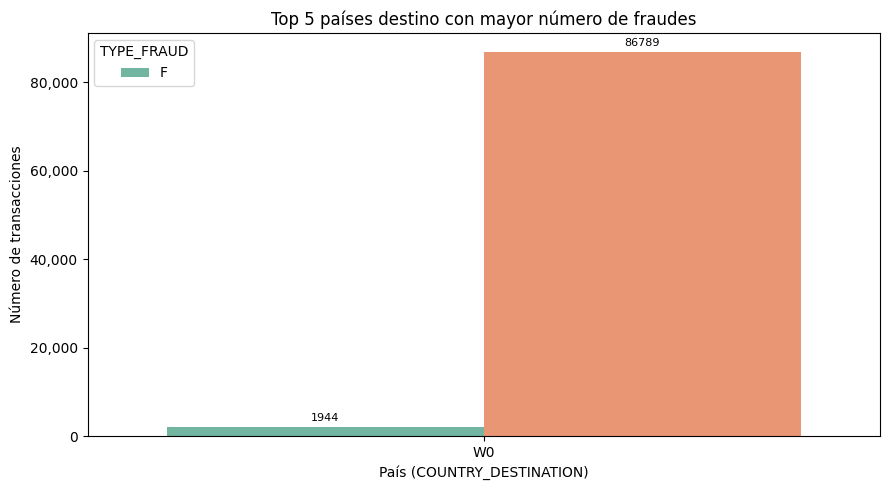

In [ ]:
# Top 5 destinos con mayor número de fraudes
top5_dest = (
    datos2[datos2['TYPE_FRAUD'] == 'F']['COUNTRY_DESTINATION']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['COUNTRY_DESTINATION'].isin(top5_dest)]
    .groupby(['COUNTRY_DESTINATION', 'TYPE_FRAUD'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('COUNTRY_DESTINATION')['n'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(9, 5))
sns.barplot(x='COUNTRY_DESTINATION', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Top 5 países destino con mayor número de fraudes')
plt.xlabel('País (COUNTRY_DESTINATION)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico evidencia que el área W0 (Mundo, todas las entidades, incluido el área de referencia, incluido IO) concentra la totalidad de los fraudes observados (1,944 casos), aunque estos representan solo el 2.2% del total de transacciones en esa región, frente al 97.8% correspondiente a operaciones no fraudulentas. Esto indica que, si bien el fraude está focalizado geográficamente en W0, su ocurrencia sigue siendo baja en términos proporcionales, confirmando el fuerte desbalance de la variable.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: COUNTRY_DESTINATION vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['COUNTRY_DESTINATION'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: COUNTRY_DESTINATION vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: COUNTRY_DESTINATION vs TYPE_FRAUD ===
Estadístico X²: 12609.8660
p-valor:        0.0000e+00
Grados de libertad: 50
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable COUNTRY_DESTINATION y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende de la institución origen de la transacción.

### Variable TYPE_TRX

In [ ]:
# Tabla de distribución de TYPE_TRX según TYPE_FRAUD
tabla_TYPE_TRX = (
    datos2.groupby('TYPE_FRAUD')['TYPE_TRX']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'TYPE_TRX': 'categoria'})
    .assign(variable='TYPE_TRX')
)
tabla_TYPE_TRX['porcentaje'] = tabla_TYPE_TRX.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_TYPE_TRX = tabla_TYPE_TRX[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_TYPE_TRX

,TYPE_FRAUD,variable,categoria,n,porcentaje
9,_Z,TYPE_TRX,DD,96303,14.58
10,_Z,TYPE_TRX,CT0,96293,14.58
11,_Z,TYPE_TRX,EMP0,92400,13.99
12,_Z,TYPE_TRX,CHQ,92171,13.95
13,_Z,TYPE_TRX,CP0,59031,8.93
14,_Z,TYPE_TRX,SER,56995,8.63
15,_Z,TYPE_TRX,MREM,52242,7.91
16,_Z,TYPE_TRX,TOTL,48119,7.28
17,_Z,TYPE_TRX,TOTL1,44336,6.71
18,_Z,TYPE_TRX,CW1,18708,2.83


La distribución del tipo de transacción según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. En los 3 casos donde hubo mayor fraude el 37.75% corresponden a transacciones tipo CPO(pagos con tarjeta), el 19.13% del tipo DD(débitos directos) y el 19.13% de EMPO(Pagos con dinero electrónico) que fueron las de mayor porcentaje frente a los otros tipos. En contraste, en el grupo donde no hubo fraude, la mayoría 14.57% fueron transacciones del tipo DD(débitos directos), asimismo, la proporción de transacciones de tipo CTO(Transferencias de crédito)(14.57%) y EMPO(Pagos con dinero electrónico)(13.98%) es ligeramente menor, pero siguen en el mismo rango de porcentajes. Esta diferencia sugiere que las transacciones realizadas de tipo CPO, DD y EMPO son más propensas a que sean fraude, sin embargo, dos de estas categorias (DD y EMPO) estuvieron también en las 3 con mayor proporción en transacciones sin fraude, la unica que se diferencia es el tipo de transacción CPO(pagos con tarjeta) que es la más propensa a que tenga fraude según el análisis a comparacion de otras que tambien presentaron fraude.

**Gráfico de barras múltiple**

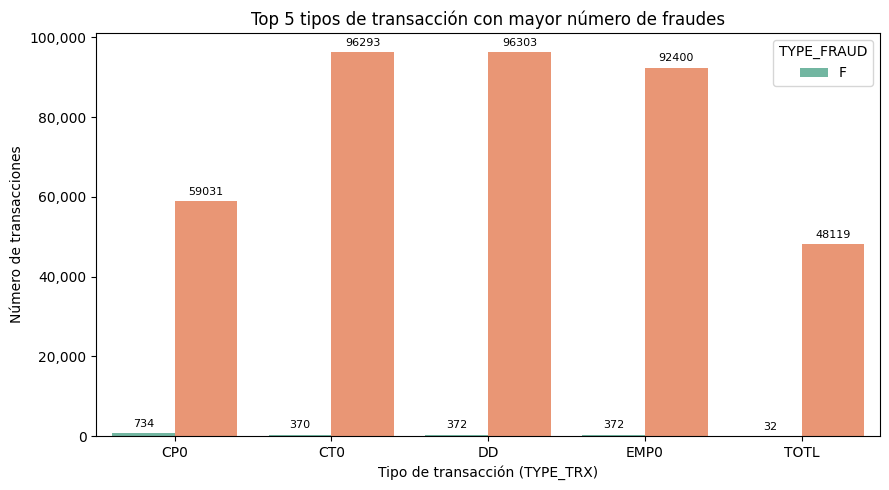

In [ ]:
# Top 5 tipos de transacción con mayor número de fraudes
top5_trx = (
    datos2[datos2['TYPE_FRAUD'] == 'F']['TYPE_TRX']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['TYPE_TRX'].isin(top5_trx)]
    .groupby(['TYPE_TRX', 'TYPE_FRAUD'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('TYPE_TRX')['n'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(9, 5))
sns.barplot(x='TYPE_TRX', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Top 5 tipos de transacción con mayor número de fraudes')
plt.xlabel('Tipo de transacción (TYPE_TRX)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico se muestran los tipos de transferencia CPO(pagos con tarjeta), CTO(Transferencias de crédito), DD(débitos directos), EMPO(Pagos con dinero electrónico) y TOTL(Transacciones de pago totales [suma de CT, DD, CP, CW, EM, CHQ, MR, OTH]); aunque estos 5 tipos de transferencia concentran el mayor número absoluto de fraudes, la proporción de transacciones fraudulentas dentro de cada tipo sigue siendo muy baja en comparación con las no fraudulentas. En todos los casos, más del 98% de las transacciones corresponden a la categoría _Z (no fraude), mientras que los fraudes (F) representan entre aproximadamente 0.1% y 1.2% del total por cada tipo de transacción. Por tanto, esto sigue demostrando el fuerte desvalance de la variable de respuesta y refleja que son casos excasos los casos de fraude frente a donde no hay.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: TYPE_TRX vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['TYPE_TRX'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: TYPE_TRX vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: TYPE_TRX vs TYPE_FRAUD ===
Estadístico X²: 2644.9980
p-valor:        0.0000e+00
Grados de libertad: 13
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable TYPE_TRX y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende de la clasificación de la transacción.

### Variable TYPE_PSP

In [ ]:
# Tabla de distribución de TYPE_PSP según TYPE_FRAUD
tabla_TYPE_PSP = (
    datos2.groupby('TYPE_FRAUD')['TYPE_PSP']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'TYPE_PSP': 'categoria'})
    .assign(variable='TYPE_PSP')
)
tabla_TYPE_PSP['porcentaje'] = tabla_TYPE_PSP.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_TYPE_PSP = tabla_TYPE_PSP[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_TYPE_PSP

,TYPE_FRAUD,variable,categoria,n,porcentaje
2,_Z,TYPE_PSP,1,386520,58.50
3,_Z,TYPE_PSP,2,270078,40.88
4,_Z,TYPE_PSP,_Z,4074,0.62
0,F,TYPE_PSP,1,1204,61.93
1,F,TYPE_PSP,2,740,38.07


La distribución de TYPE_PSP según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. Entre las transacciones donde hubo fraude, el 61.93% corresponden a transacciones con rol tipo 1(PSP del pagador) y el 38.06% del tipo 2(PSP del beneficiario). En contraste, en el grupo donde no hubo fraude, la mayoría 58.5% fueron transacciones del rol tipo 1, mientras que el 40.87% al rol tipo 2 y 0.61% no aplica. Esta diferencia sugiere que las transacciones del rol tipo 1 son más propensas a que sean fraude, En general, las transacciones del tipo 1 son las que más se usan y son las que tienen mayor porcentaje de fraude respecto a las de tipo 2.

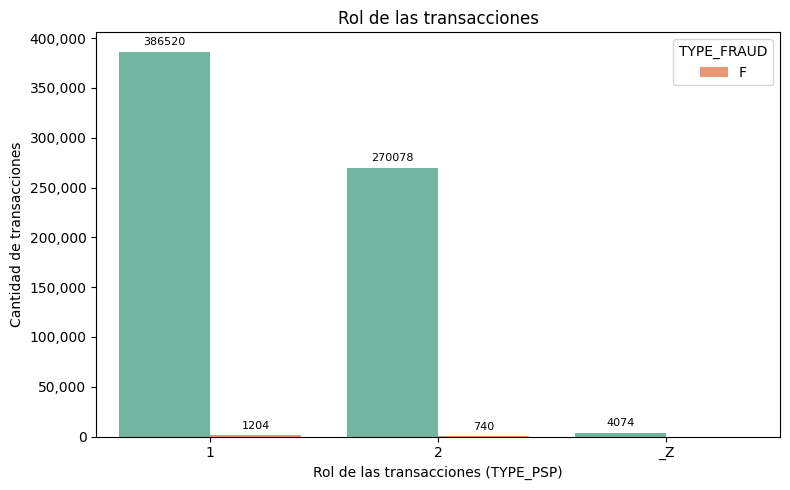

In [ ]:
# Gráfico de barras múltiple: TYPE_PSP vs TYPE_FRAUD
df_plot = tabla_TYPE_PSP.copy()

plt.figure(figsize=(8, 5))
sns.barplot(x='categoria', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Rol de las transacciones')
plt.xlabel('Rol de las transacciones (TYPE_PSP)')
plt.ylabel('Cantidad de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

La mayoría de las transacciones se concentran en el rol 1 (Payer's PSP) con 58,5%, seguido del rol 2 (Payee's PSP) con 40,9%, mientras que la categoría _Z es marginal (0,6%). En los casos de fraude (F) se mantiene esta tendencia, predominando también el rol 1 (61,9%), lo que indica que tanto el volumen total como los eventos fraudulentos se concentran principalmente en el PSP del pagador.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: TYPE_PSP vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['TYPE_PSP'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: TYPE_PSP vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: TYPE_PSP vs TYPE_FRAUD ===
Estadístico X²: 19.6388
p-valor:        5.4386e-05
Grados de libertad: 2
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable TYPE_PSP y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende de la clasificación de la entidad procesa la transacción.

### Variable UNIT_

In [ ]:
# Tabla de distribución de UNIT_ según TYPE_FRAUD
tabla_UNIT = (
    datos2.groupby('TYPE_FRAUD')['UNIT_']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'UNIT_': 'categoria'})
    .assign(variable='UNIT_')
)
tabla_UNIT['porcentaje'] = tabla_UNIT.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_UNIT = tabla_UNIT[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_UNIT

,TYPE_FRAUD,variable,categoria,n,porcentaje
5,_Z,UNIT_,PN,295384,44.71
6,_Z,UNIT_,EUR,257589,38.99
7,_Z,UNIT_,XDF,60941,9.22
8,_Z,UNIT_,PN_R_POP,7724,1.17
9,_Z,UNIT_,EUR_R_POP,7688,1.16
10,_Z,UNIT_,EUR_R_TT,7555,1.14
11,_Z,UNIT_,PN_R_TT,7523,1.14
12,_Z,UNIT_,EUR_R_PNT,7061,1.07
13,_Z,UNIT_,EUR_R_B1GQ,4487,0.68
14,_Z,UNIT_,XDF_R_TT,1560,0.24


La distribución de la unidad o divisa involucrada en la transacciones según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. En los 3 casos donde hubo mayor fraude el 49.58% corresponden a transacciones con divisa o unidad PN(número puro), el 41.25% de EUR(EURO) y el 8.33% de XDF(moneda nacional) que fueron las de mayor porcentaje frente a los otros tipos. En contraste, en el grupo donde no hubo fraude, la mayoría 44.7% fueron transacciones con tipo de divisa o unidad EUR, asimismo, la proporción de transacciones con XDF(38.98%) y PN_R_POP(Número puro per cápita)(13.98%) es ligeramente menor. Esta diferencia sugiere que las transacciones realizadas con divisa o unidad PN,EUR y XDF son más propensas a que sean fraude, sin embargo, dos de estas categorias (EUR y XDF) estuvieron también en las 3 con mayor proporción en transacciones sin fraude, la unica que se diferencia es el tipo de transacción donde se usó PN(número puro) que es la más propensa a que tenga fraude según el análisis a comparacion de otras que tambien presentaron fraude.

**Gráfico de barras multiple**

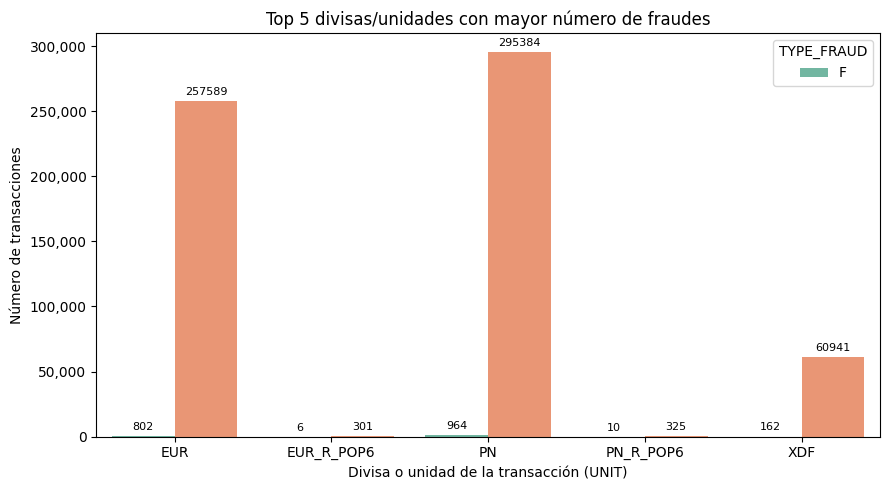

In [ ]:
# Top 5 unidades con mayor número de fraudes
top5_unit = (
    datos2[datos2['TYPE_FRAUD'] == 'F']['UNIT_']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['UNIT_'].isin(top5_unit)]
    .groupby(['UNIT_', 'TYPE_FRAUD'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('UNIT_')['n'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(9, 5))
sns.barplot(x='UNIT_', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Top 5 divisas/unidades con mayor número de fraudes')
plt.xlabel('Divisa o unidad de la transacción (UNIT)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

La mayoría de las transacciones se registran en la categoría _Z (sin fraude), con proporciones cercanas al 99.7% en todas las UNIT, mientras que F (con fraude) representa apenas alrededor del 0.3%. Aunque PN, EUR y XDF concentran los mayores volúmenes, la incidencia relativa del fraude se mantiene estable entre monedas, lo que sugiere que el fraude se explica más por el volumen total de operaciones que por la unidad de transacción.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: UNIT vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['UNIT_'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: UNIT vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: UNIT vs TYPE_FRAUD ===
Estadístico X²: 262.2064
p-valor:        8.5336e-48
Grados de libertad: 14
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable UNIT y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende de unidad o divisa involucrada en la transacción.

### Variable YEAR

In [ ]:
# Tabla de distribución de YEAR según TYPE_FRAUD (primeras 40 filas)
tabla_YEAR = (
    datos2.groupby('TYPE_FRAUD')['YEAR']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'YEAR': 'categoria'})
    .assign(variable='YEAR')
)
tabla_YEAR['porcentaje'] = tabla_YEAR.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_YEAR = tabla_YEAR[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_YEAR.head(40)

,TYPE_FRAUD,variable,categoria,n,porcentaje
0,F,YEAR,2023-S1,282,14.51
1,F,YEAR,2023-S2,282,14.51
2,F,YEAR,2024-S1,282,14.51
3,F,YEAR,2024-S2,282,14.51
4,F,YEAR,2025-S1,282,14.51
5,F,YEAR,2022-S1,268,13.79
6,F,YEAR,2022-S2,266,13.68
7,_Z,YEAR,2023-S1,34837,5.27
8,_Z,YEAR,2023-S2,34284,5.19
9,_Z,YEAR,2024-S1,34190,5.18


Para este analisis la variable YEAR se excluye frente a TYPE_FRAUD porque presenta baja frecuencia por categoría, haciendo que sea poco interpretable. Además, YEAR corresponde a un código estructural compuesto que integra múltiples atributos técnicos, por lo que no representa una característica explicativa independiente con significado analítico propio. Cabe aclarar que aparecen pocas filas porque solo se mostraron las 40 primeras. Asimismo, no se realizará la prueba de independencia para esta variable con la de respuesta porque no es necesario para nuestro análisis y por la forma de esta variable.

### TYPE_AMOUNT

In [ ]:
# Tabla de distribución de TYPE_AMOUNT según TYPE_FRAUD (primeras 40 filas)
tabla_TYPE_AMOUNT = (
    datos2.groupby('TYPE_FRAUD')['TYPE_AMOUNT']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'TYPE_AMOUNT': 'categoria'})
    .assign(variable='TYPE_AMOUNT')
)
tabla_TYPE_AMOUNT['porcentaje'] = tabla_TYPE_AMOUNT.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_TYPE_AMOUNT = tabla_TYPE_AMOUNT[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_TYPE_AMOUNT.head(40)

,TYPE_FRAUD,variable,categoria,n,porcentaje
0,F,TYPE_AMOUNT,A,1475,75.87
1,F,TYPE_AMOUNT,P,251,12.91
2,F,TYPE_AMOUNT,Q,176,9.05
3,F,TYPE_AMOUNT,M,42,2.16
4,_Z,TYPE_AMOUNT,A,481305,72.85
5,_Z,TYPE_AMOUNT,Q,93425,14.14
6,_Z,TYPE_AMOUNT,M,48955,7.41
7,_Z,TYPE_AMOUNT,P,35065,5.31
8,_Z,TYPE_AMOUNT,L,1277,0.19
9,_Z,TYPE_AMOUNT,E,645,0.10


Para este análisis se no excluirán las variables L, M y Q porque a pesar que corresponden a valores faltantes, la variable de respuesta de la investigación es si hubo o no fraude, por tanto, se quiere identificar eso antes que saber de cuanto fue el fraude. En este caso, La distribución del estado de la observación según TYPE_FRAUD muestra diferencias relevantes en los patrones observados. Entre las transacciones con fraude (F), la categoría A(valor normal) es claramente mayoritaria 75.87%, seguida por P(valor provisional) (12.91%) y Q(valor faltante,reprimido) (9.05%), mientras que M(valor faltante, los datos no pueden existir) presenta una participación reducida (2.16%). En contraste, en las transacciones sin fraude (_Z), aunque A también predomina (72.85%), se aprecia una mayor presencia relativa de Q (14.14%), M (7.41%) y P (5.30%), además de categorías marginales como E y L. Esta diferencia sugiere que los eventos de fraude tienden a concentrarse principalmente en el estado A, mientras que las operaciones legítimas presentan una distribución más diversificada, lo que podría ser relevante para el análisis de riesgo y la identificación de patrones de comportamiento.

**Gráfico de barras multiple**

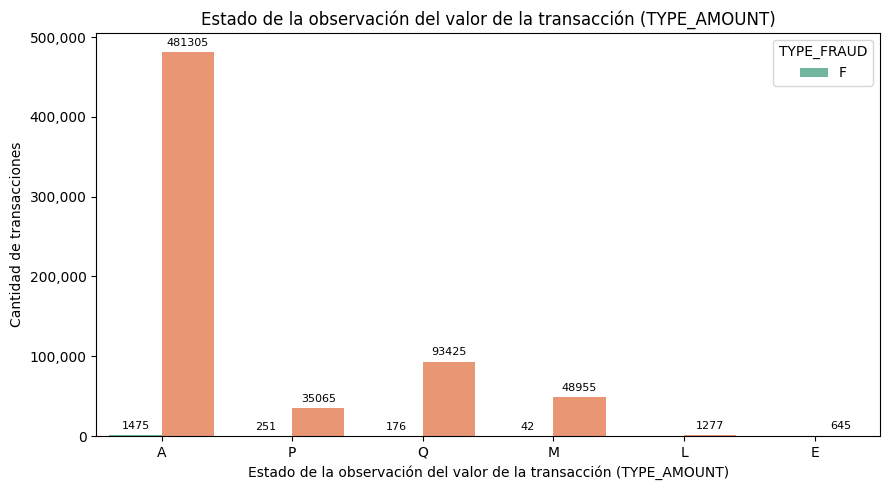

In [ ]:
# Gráfico de barras múltiple: TYPE_AMOUNT vs TYPE_FRAUD
df_plot = tabla_TYPE_AMOUNT.copy()

plt.figure(figsize=(9, 5))
sns.barplot(x='categoria', y='n', hue='TYPE_FRAUD', data=df_plot,
            palette='Set2', dodge=True)

ax = plt.gca()
for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.0f', padding=3, fontsize=8)

plt.title('Estado de la observación del valor de la transacción (TYPE_AMOUNT)')
plt.xlabel('Estado de la observación del valor de la transacción (TYPE_AMOUNT)')
plt.ylabel('Cantidad de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico de TYPE_AMOUNT indica que la categoría A concentra la mayor parte de las transacciones (≈72.9%), seguida por Q (14.1%), M (7.4%) y P (5.3%), mientras que E y L son marginales. En los casos de fraude (F) se mantiene la misma estructura general, con predominio de A, aunque con una participación relativamente mayor en P y Q frente al conjunto total. Esto sugiere que, si bien la distribución global está dominada por A, ciertas categorías como P y Q adquieren mayor relevancia relativa dentro de las operaciones fraudulentas.

**Prueba de independencia**

In [ ]:
# Prueba chi-cuadrado: TYPE_AMOUNT vs TYPE_FRAUD
tabla_chi = pd.crosstab(datos2['TYPE_AMOUNT'], datos2['TYPE_FRAUD'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("=== Chi-cuadrado: TYPE_AMOUNT vs TYPE_FRAUD ===")
print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

=== Chi-cuadrado: TYPE_AMOUNT vs TYPE_FRAUD ===
Estadístico X²: 326.1143
p-valor:        2.4212e-68
Grados de libertad: 5
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable TYPE_AMOUNT y TYPE_FRAUD son independientes, es decir, si hay fraude o no depende del monto de la transacción.

### Variable DESCRIPTION

In [ ]:
# Tabla de distribución de DESCRIPTION según TYPE_FRAUD (primeras 40 filas)
tabla_DESCRIPTION = (
    datos2.groupby('TYPE_FRAUD')['DESCRIPTION']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'DESCRIPTION': 'categoria'})
    .assign(variable='DESCRIPTION')
)
tabla_DESCRIPTION['porcentaje'] = tabla_DESCRIPTION.groupby('TYPE_FRAUD')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_DESCRIPTION = tabla_DESCRIPTION[['TYPE_FRAUD', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_DESCRIPTION.head(40)

,TYPE_FRAUD,variable,categoria,n,porcentaje
0,F,DESCRIPTION,"Direct debits, fraudulent transactions, sent",372,19.14
1,F,DESCRIPTION,"E-money payments, fraudulent transactions, sent",372,19.14
2,F,DESCRIPTION,"Credit transfers, fraudulent transactions, sent",370,19.03
3,F,DESCRIPTION,"Card payments, fraudulent transactions, sent",368,18.93
4,F,DESCRIPTION,"Card payments, fraudulent transactions, received",366,18.83
5,F,DESCRIPTION,"Total payment transactions, incl. cash withdra...",32,1.65
6,F,DESCRIPTION,"Cash withdrawals using cards, fraudulent trans...",30,1.54
7,F,DESCRIPTION,"Money remittances, fraudulent transactions, sent",30,1.54
8,F,DESCRIPTION,"Cheques, fraudulent transactions, sent",2,0.10
9,F,DESCRIPTION,"Other payment services, fraudulent transaction...",2,0.10


Para este analisis la variable DESCRIPTION se excluye frente a TYPE_FRAUD porque corresponde a un código estructural compuesto que integra múltiples atributos técnicos, en esta variable se describe la transacción y dice si hubo fraude, el tipo de transacción y si fue enviada, por lo cual, se tiene esta informacion de otras variables ya analizadas previamente. Asimismo, no se realizará la prueba de independencia para esta variable con la de respuesta porque no es necesario para nuestro análisis y por la forma de esta variable.